<a href="https://colab.research.google.com/github/ErikFantomex/MPI_Curso/blob/master/Manual_Recipientes_ppyd.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Contando números primos**


## Código

In [ ]:
%%writefile contando_primos.cpp
#include "mpi.h" 
#include<cstdio> 
#include<cstdlib> 

#define BLOCK_LOW(id,p,n) ((id)*(n)/(p))
#define BLOCK_HIGH(id,p,n) (BLOCK_LOW((id)+1,p,n)-1)
#define BLOCK_SIZE(id,p,n)(BLOCK_HIGH(id,p,n)-BLOCK_LOW(id,p,n)+1)

int main(int argc, char **argv ) {      
  MPI_Init( &argc , &argv); 
  int id, i, j, np, n, ind, gap, inicio, fin, num_elems_rango;

  MPI_Comm_rank(MPI_COMM_WORLD, &id); 
  MPI_Comm_size(MPI_COMM_WORLD, &np); 

  n      = atoi(argv[1]);
  inicio = BLOCK_LOW(id, np, n) + 1; // para que empiece en 1
  fin    = BLOCK_HIGH(id, np, n) + 1;
  num_elems_rango = BLOCK_SIZE(id, np, n);

  int cantNumPrimos = 0;

  if (inicio == 1) inicio++;  // Debe haber otra forma de arreglarlo.

  for (int i = inicio; i < fin; i++) {
      bool esPrimo = true;

      for (int j = 2; j < i; j++) {
          if (i % j == 0) {
              esPrimo = false;

              break;
          }
      }

      if (esPrimo) {
          std::cout << i << ' ';
          cantNumPrimos++;
      }
  }

  std::cout << "\nProcesador [" << id << "], rango (" << inicio << ", " << fin << "), encontrados: " << cantNumPrimos << std::endl;
 
  MPI_Finalize(); 
} 

Writing contando_primos.cpp


## Bash

In [ ]:
%%script bash

#!/bin/bash

# PBS Job Script para uso de mpi

#Modifique segun el numero de procesadores necesitados

#PBS -l nodes=1:ppn=4

#PBS -l walltime=00:10:00

#PBS -N MPI

#PBS -V

#PBS -q batch

#PBS -k eo

##source /opt/intel/oneapi/setvars.sh

mpicxx contando_primos.cpp -o contando_primos

mpirun --allow-run-as-root -np 5 contando_primos 100

23 29 31 37 
Procesador [1], rango (21, 40), encontrados: 4
83 89 97 
Procesador [4], rango (81, 100), encontrados: 3
41 43 47 53 59 
61 67 71 73 79 
Procesador [3], rango (61, 80), encontrados: 5
2 3 5 7 11 13 17 19 
Procesador [0], rango (2, 20), encontrados: 8
Procesador [2], rango (41, 60), encontrados: 5


# **Total de Números Primos**

### Código

In [ ]:
%%writefile total_num_primos.cpp
#include "mpi.h"
#include<cstdio> 
#include<cstdlib>
#include<iostream>
#include<cstring>

#include<sys/time.h>

using namespace std;

#define BLOCK_LOW(id,p,n) ((id)*(n)/(p))
#define BLOCK_HIGH(id,p,n) (BLOCK_LOW((id)+1,p,n)-1)
#define BLOCK_SIZE(id,p,n)(BLOCK_HIGH(id,p,n)-BLOCK_LOW(id,p,n)+1)

int main(int argc, char **argv) {      
  MPI_Init( &argc , &argv); 
  int id, i, j, np, n, ind, inicio, fin, num_elems_rango, root = 0;

  MPI_Comm_rank(MPI_COMM_WORLD, &id); 
  MPI_Comm_size(MPI_COMM_WORLD, &np); 

  n      = atoi(argv[1]);
  inicio = BLOCK_LOW(id, np, n) + 1; // para que empiece en 1
  fin    = BLOCK_HIGH(id, np, n) + 1;
//  num_elems_rango = BLOCK_SIZE(id, np, n);

  int cantNumPrimos = 0;

  if (inicio == 1) inicio++;  // Debe haber otra forma de arreglarlo.

  for (int i = inicio; i < fin; i++) {
      bool esPrimo = true;

      for (int j = 2; j < i; j++) {
          if (i % j == 0) {
              esPrimo = false;

              break;
          }
      }

      if (esPrimo) {
          std::cout << i << ' ';
          cantNumPrimos++;
      }
  }

  cout << "\nProcesador [" << id << "], rango [" << inicio << ", " << fin << "], encontrados: " << cantNumPrimos << endl;

  // Realizamos la transferencia de información al procesador 0 desde los demás.
  MPI_Send(&cantNumPrimos, 1, MPI_INT, root, 9, MPI_COMM_WORLD);

  if( id == root ){
      int primosTotales = 0;
      for( i = 0 ; i < np ; i++ ){
          MPI_Recv(&cantNumPrimos, 1, MPI_INT, i, 9, MPI_COMM_WORLD, MPI_STATUS_IGNORE);
          
          primosTotales += cantNumPrimos;
      }
  
    cout << "\nRango [1, " << n << "]" << endl;
    cout << "Total de números primos: " << primosTotales << endl;

  }
 
  MPI_Finalize(); 
} 

Writing total_num_primos.cpp


### BASH

In [ ]:
%%script bash

#!/bin/bash

# PBS Job Script para uso de mpi

#Modifique segun el numero de procesadores necesitados

#PBS -l nodes=1:ppn=4

#PBS -l walltime=00:10:00

#PBS -N MPI

#PBS -V

#PBS -q batch

#PBS -k eo

##source /opt/intel/oneapi/setvars.sh

mpicxx total_num_primos.cpp -o total_primos

mpirun --allow-run-as-root -np 5 total_primos 100

2 3 5 7 11 13 17 19 
Procesador [0], rango [2, 20], encontrados: 8
23 29 31 37 
61 67 71 73 79 
Procesador [3], rango [61, 80], encontrados: 5
41 43 47 53 59 
Procesador [2], rango [41, 60], encontrados: 5
Procesador [1], rango [21, 40], encontrados: 4
83 89 97 
Procesador [4], rango [81, 100], encontrados: 3

Rango [1, 100]
Total de números primos: 25


# **Tarea 1 - 26/Ago/2021**

### *Código*

In [ ]:
%%writefile red_circular.cpp
#include "mpi.h"
#include <iostream>
#include <cstring>
 
using namespace std;
 
int main( ) {
    MPI_Init(NULL, NULL);
 
    int cpu_ID, total_CPU;
    char salida[100], entrada[100];
 
    MPI_Comm_size(MPI_COMM_WORLD, &total_CPU);  // Número total de procesos.
    MPI_Comm_rank(MPI_COMM_WORLD, &cpu_ID);     // Valor de nuestro identificador.
 
    int root = 0;
    int last = total_CPU - 1;
    int next = cpu_ID + 1;
    int prev = cpu_ID - 1;
 
    if ( cpu_ID == root ) {
        // Enviando el mensaje.
        sprintf(salida, "HOLA PROCESO [%d], ATENTAMENTE PROCESO [%d].\n", next, root);
        MPI_Send(salida, strlen(salida) + 1, MPI_CHAR, next, root * 10 + 1, MPI_COMM_WORLD);
 
        // Recibiendo el mensaje.
        MPI_Recv(entrada, 100, MPI_CHAR, last, last * 10 + 1, MPI_COMM_WORLD, MPI_STATUS_IGNORE); 
        cout << "Soy el proceso [" << root << "], recibí el mensaje:\n" << entrada;
 
    } else if ( cpu_ID == last ) {
        // Enviando el mensaje.
        sprintf(salida, "HOLA PROCESO [%d], ATENTAMENTE PROCESO [%d].\n", root, last);
        MPI_Send(salida, strlen(salida) + 1, MPI_CHAR, root, last * 10 + 1, MPI_COMM_WORLD);
 
        // Recibiendo el mensaje.
        MPI_Recv(entrada, 100, MPI_CHAR, prev, prev * 10 + 1, MPI_COMM_WORLD, MPI_STATUS_IGNORE); 
        cout << "Soy el proceso [" << last << "], recibí el mensaje:\n" << entrada;
 
    } else {
        // Enviando el mensaje.
        sprintf(salida, "HOLA PROCESO [%d], ATENTAMENTE PROCESO [%d].\n", next, cpu_ID);
        MPI_Send(salida, strlen(salida) + 1, MPI_CHAR, next, cpu_ID * 10 + 1, MPI_COMM_WORLD);
 
        // Recibiendo el mensaje.
        MPI_Recv(entrada, 100, MPI_CHAR, prev, prev * 10 + 1, MPI_COMM_WORLD, MPI_STATUS_IGNORE); 
        cout << "Soy el proceso [" << cpu_ID << "], recibí el mensaje:\n" << entrada;
 
    }
                            
    MPI_Finalize(); 
    return 0;
}

Writing red_circular.cpp


### *Bash*

In [ ]:
%%script bash
#!/bin/bash

# PBS Job Script para uso de mpi

#Modifique segun el numero de procesadores necesitados

#PBS -l nodes=1:ppn=4

#PBS -l walltime=00:10:00

#PBS -N MPI

#PBS -V

#PBS -q batch

#PBS -k eo

##source /opt/intel/oneapi/setvars.sh

mpicxx red_anillo.cpp -o red_anillo

mpirun --allow-run-as-root -np 5 red_anillo

# **Tarea 2 **

### *Código - Versión 1*

In [ ]:
%%writefile encontrando_primos_contrarreloj.cpp

#include <iostream>
#include <cstdlib>
#include <cmath>
#include "mpi.h"

using std::cout;
using std::endl;

#define BLOCK_LOW(id,p,n) ((id)*(n)/(p))
#define BLOCK_HIGH(id,p,n) (BLOCK_LOW((id)+1,p,n)-1)
#define BLOCK_SIZE(id,p,n)(BLOCK_HIGH(id,p,n)-BLOCK_LOW(id,p,n)+1)

int main(int argc, char **argv ) {      
  MPI_Init( &argc , &argv); 
  int id, i, j, np, n, ind, inicio, fin, num_elems_rango, root = 0;
  MPI_Comm_rank(MPI_COMM_WORLD, &id); 
  MPI_Comm_size(MPI_COMM_WORLD, &np); 

  n      = atoi(argv[1]);
  inicio = BLOCK_LOW(id, np, n) + 1; // para que empiece en 1
  fin    = BLOCK_HIGH(id, np, n) + 1;
  num_elems_rango = BLOCK_SIZE(id, np, n);

  int cantNumPrimos = 0;

  // Comenzamos la medición del tiempo.
  MPI_Barrier(MPI_COMM_WORLD);
  double inicioTiempo = MPI_Wtime();

  for (int i = (inicio == 1 ? 2 : inicio); i < fin; i++) {
      bool esPrimo = true;

      for (int j = 2; j < i; j++) {
          if (i % j == 0) {
              esPrimo = false;

              break;
          }
      }

      if (esPrimo) cantNumPrimos++;
  }

  // Transferimos cantNumPrimos desde los otros procesadores hacia root.
  MPI_Send(&cantNumPrimos, 1, MPI_INT, root, 9, MPI_COMM_WORLD);

  if ( id == root ) {
    int primosTotales = 0;

    for ( i = 0 ; i < np ; i++ ) {
      MPI_Recv(&cantNumPrimos, 1, MPI_INT, i, 9, MPI_COMM_WORLD, MPI_STATUS_IGNORE);
      primosTotales += cantNumPrimos;
    }

    // Finalizamos la medición del tiempo.
    double finTiempo = MPI_Wtime();

    double tiempoTotal = finTiempo - inicioTiempo;
  
    cout << "Cantidad de procesadores: " << np << endl;
    cout << "Rango [1, " << n << "]" << endl;
    cout << "Total de números primos: " << primosTotales << endl;
    cout << "Tiempo transcurrido: " << tiempoTotal << " segundos.\n" << endl;
  }
 
  MPI_Finalize(); 
}

Overwriting encontrando_primos_contrarreloj.cpp


### *Bash - Versión 1*

In [ ]:
%%script bash

#!/bin/bash

#PBS Job Script para uso de MPI

#Modifique según el número de procesadores necesitados

#PBS -l nodes=1:ppn=4
#PBS -l walltime=00:10:00
#PBS -N MPI
#PBS -V
#PBS -q batch
#PBS -k eo

##source /opt/intel/oneapi/setvars.sh

mpicxx encontrando_primos_contrarreloj.cpp -o encontrando_primos_contrarreloj


  mpirun --allow-run-as-root -np $2 encontrando_primos_contrarreloj 2000


----------------------------------------------------------------------------
Open MPI has detected that a parameter given to a command line
option does not match the expected format:

  Option: np
  Param:  encontrando_primos_contrarreloj

This is frequently caused by omitting to provide the parameter
to an option that requires one. Please check the command line and try again.
----------------------------------------------------------------------------


CalledProcessError: ignored

### *Código - Versión 2*

In [ ]:
%%writefile encontrando_primos_contrarreloj_02.cpp

#include <iostream>
#include <cstdlib>
#include "mpi.h"

using std::cout;
using std::endl;

#define BLOCK_LOW(id,p,n) ((id)*(n)/(p))
#define BLOCK_HIGH(id,p,n) (BLOCK_LOW((id)+1,p,n)-1)
#define BLOCK_SIZE(id,p,n)(BLOCK_HIGH(id,p,n)-BLOCK_LOW(id,p,n)+1)

int main(int argc, char **argv ) {      
  MPI_Init( &argc , &argv); 
  int id, i, j, np, n, ind, inicio, fin, num_elems_rango, root = 0;

  MPI_Comm_rank(MPI_COMM_WORLD, &id); 
  MPI_Comm_size(MPI_COMM_WORLD, &np); 

  n      = atoi(argv[1]);
  inicio = BLOCK_LOW(id, np, n) + 1; // para que empiece en 1
  fin    = BLOCK_HIGH(id, np, n) + 1;
  num_elems_rango = BLOCK_SIZE(id, np, n);

  int cantNumPrimos = 0;

  // Comenzamos la medición del tiempo.
  MPI_Barrier(MPI_COMM_WORLD);
  double inicioTiempo = MPI_Wtime();

  for (int i = (inicio == 1 ? 2 : inicio); i < fin; i++) {
      bool esPrimo = true;

      for (int j = 2; j < i; j++) {
          if (i % j == 0) {
              esPrimo = false;

              break;
          }
      }

      if (esPrimo) cantNumPrimos++;
  }

  // Transferimos cantNumPrimos desde los otros procesadores hacia root.
  int numPrimosTotales = 0;
  MPI_Reduce(&cantNumPrimos, &numPrimosTotales, 1, MPI_INT, MPI_SUM, root, MPI_COMM_WORLD);

  if ( id == root ) {
    // Finalizamos la medición del tiempo.
    double finTiempo = MPI_Wtime();

    double tiempoTotal = finTiempo - inicioTiempo;

    cout << "Cantidad de procesadores: " << np << endl;
    cout << "Rango [1, " << n << "]" << endl;
    cout << "Total de números primos: " << numPrimosTotales << endl;
    cout << "Tiempo transcurrido: " << tiempoTotal << " segundos.\n" << endl;
  }
 
  MPI_Finalize(); 
}

Writing encontrando_primos_contrarreloj_02.cpp


### *Bash - Versión 2*

In [ ]:
%%script bash

#!/bin/bash

# PBS Job Script para uso de mpi

#Modifique segun el numero de procesadores necesitados

#PBS -l nodes=1:ppn=4
#PBS -l walltime=00:10:00
#PBS -N MPI
#PBS -V
#PBS -q batch
#PBS -k eo

##source /opt/intel/oneapi/setvars.sh

mpicxx encontrando_primos_contrarreloj_02.cpp -o encontrando_primos_contrarreloj_02

max_procesadores=6

for ((i = 1; i <= $max_procesadores; ++i)); do
  mpirun --allow-run-as-root -np 1 encontrando_primos_contrarreloj_02 2100
done

Cantidad de procesadores: 1
Rango [1, 2100]
Total de números primos: 317
Tiempo transcurrido: 0.00124448 segundos.

Cantidad de procesadores: 1
Rango [1, 2100]
Total de números primos: 317
Tiempo transcurrido: 0.00113722 segundos.

Cantidad de procesadores: 1
Rango [1, 2100]
Total de números primos: 317
Tiempo transcurrido: 0.00113539 segundos.

Cantidad de procesadores: 1
Rango [1, 2100]
Total de números primos: 317
Tiempo transcurrido: 0.00123956 segundos.

Cantidad de procesadores: 1
Rango [1, 2100]
Total de números primos: 317
Tiempo transcurrido: 0.00116517 segundos.

Cantidad de procesadores: 1
Rango [1, 2100]
Total de números primos: 317
Tiempo transcurrido: 0.0011314 segundos.



### *Código - Versión 3*

In [ ]:
%%writefile encontrando_primos_secuencial.c

#include <stdio.h>
#include <stdlib.h>
#include <time.h>
#include <sys/time.h>


float dt(struct t *inicio, struct t *final) {
  return (final->tv_sec - inicio->tv_sec) + 1e-6*(final->tv_usec - inicio->tv_usec);
}

int main(int argc, char **argv ) {
      
    int i,j,bandera;
    int n = atoi(argv[1]);
    time_t comienzo = time(NULL);  
    
    struct t inicio;
    struct t final;    

    gettimeofday(&inicio, NULL);

    int evaluacion = 0;
    for(i = 2; i <= n; i++){
      bandera = 0;
      for(j = 2; j<= i/2; j++){
        if(i%j == 0){
          bandera = 1;
            break;
        }
      }
      if(bandera == 0){
        evaluacion++;
      }
    }           
  printf ("Total de números primos: %d \n" ,evaluacion);
  gettimeofday(&final,NULL); // Tiempo
  printf ("Tiempo transcurrido en segundos:", dt(&inicio,&final));
  
  return 0;

}

Writing encontrando_primos_secuencial.c


In [ ]:
#!/bin/bash

#SBATCH --nodes=1
#SBATCH --ntasks-per-node=3
#SBATCH --job-name=Abraham
#SBATCH --time=4:00:00
#SBATCH --constraint=broadwell
#SBATCH --partition=general

module load intel/oneAPI-2021

echo "VERSION SECUENCIAL"
echo "n=2M"
gcc Primos_Secuencial.c  -o Primos
./Primos 2000000

encontrando_primos_secuencial.c: In function ‘float dt(t*, t*)’:
encontrando_primos_secuencial.c:9:16: error: invalid use of incomplete type ‘struct t’
   return (final->tv_sec - inicio->tv_sec) + 1e-6*(final->tv_usec - inicio->tv_usec);
                ^~
encontrando_primos_secuencial.c:8:17: note: forward declaration of ‘struct t’
 float dt(struct t *inicio, struct t *final) {
                 ^
encontrando_primos_secuencial.c:9:33: error: invalid use of incomplete type ‘struct t’
   return (final->tv_sec - inicio->tv_sec) + 1e-6*(final->tv_usec - inicio->tv_usec);
                                 ^~
encontrando_primos_secuencial.c:8:17: note: forward declaration of ‘struct t’
 float dt(struct t *inicio, struct t *final) {
                 ^
encontrando_primos_secuencial.c:9:56: error: invalid use of incomplete type ‘struct t’
   return (final->tv_sec - inicio->tv_sec) + 1e-6*(final->tv_usec - inicio->tv_usec);
                                                        ^~
encontrando_pr

CalledProcessError: ignored

In [ ]:
#!/bin/bash

#SBATCH --nodes=1
#SBATCH --ntasks-per-node=3
#SBATCH --job-name=Abraham
#SBATCH --time=4:00:00
#SBATCH --constraint=broadwell
#SBATCH --partition=general

module load intel/oneAPI-2021

echo "VERSION SECUENCIAL"
echo "n=2M"
gcc Primos_Secuencial.c  -o Primos
./Primos 2000000

### *Bash - Versión 3*

In [ ]:
%%script bash

#!/bin/bash

# PBS Job Script para uso de mpi

#Modifique segun el numero de procesadores necesitados

#PBS -l nodes=1:ppn=4
#PBS -l walltime=00:10:00
#PBS -N MPI
#PBS -V
#PBS -q batch
#PBS -k eo

##source /opt/intel/oneapi/setvars.sh

mpicxx encontrando_primos_contrarreloj_03.cpp -o encontrando_primos_contrarreloj_03

 mpirun --allow-run-as-root -np 1 encontrando_primos_contrarreloj_03

Process is terminated.


# **Tarea 03 - 09/Sep/2022 - Máximo intervalo entre números primos**

### *Código - Versión 1*

In [ ]:
%%writefile encontrarGap.cpp

#include <iostream>
#include <cstdlib>
#include "mpi.h"

using std::cout;
using std::endl;

#define BLOCK_LOW(id,p,n) ((id)*(n)/(p))
#define BLOCK_HIGH(id,p,n) (BLOCK_LOW((id)+1,p,n)-1)
#define BLOCK_SIZE(id,p,n)(BLOCK_HIGH(id,p,n)-BLOCK_LOW(id,p,n)+1)

int main(int argc, char **argv ) {      
  MPI_Init( &argc , &argv); 
  int id, i, j, np, n, gap, inicio, fin, num_elems_rango, root = 0;

  MPI_Comm_size(MPI_COMM_WORLD, &np);
  MPI_Comm_rank(MPI_COMM_WORLD, &id);

  n      = atoi(argv[1]);
  inicio = BLOCK_LOW(id, np, n) + 1; // para que empiece en 1
  fin    = BLOCK_HIGH(id, np, n) + 1;
  num_elems_rango = BLOCK_SIZE(id, np, n);

  int maxGap = 0, primerPrimAbs = 0, primerPrimo = 0, ultimoPrimo = 0;

  cout << "numProc_" << id << ", rango_" << inicio <<','<< fin << endl;

  // Comenzamos la medición del tiempo.
  MPI_Barrier(MPI_COMM_WORLD);
  double inicioTiempo = MPI_Wtime();

  for (int i = (inicio == 1 ? 2 : inicio); i <= fin; i++) {
      bool esPrimo = true;

      for (int j = 2; j < i; j++) {
          if (i % j == 0) {
              esPrimo = false;

              break;
          }
      }
      
      if (esPrimo) {
          if (primerPrimo == 0) {
              primerPrimAbs = primerPrimo = i;
          } else if (ultimoPrimo == 0) {
              ultimoPrimo = i;

              maxGap = ultimoPrimo - primerPrimo;
          } else {
              primerPrimo = ultimoPrimo;
              ultimoPrimo = i;

              if (maxGap < ultimoPrimo - primerPrimo) {
                  maxGap = ultimoPrimo - primerPrimo;
              }
          }
      }
  }

  if (ultimoPrimo == 0) {
      ultimoPrimo = primerPrimo;
  }

  if (id != np - 1 && ultimoPrimo != 0) {
      // Enviar ultimoPrimo con SEND().
      MPI_Send(&ultimoPrimo, 1, MPI_INT, id + 1, id * 10 + 1, MPI_COMM_WORLD);   
  }
  
  if (id != root) {
      int primoRecibido;
      MPI_Recv(&primoRecibido, 1, MPI_INT, id - 1, (id - 1) * 10 + 1, MPI_COMM_WORLD, MPI_STATUS_IGNORE);

      if (primoRecibido > 1 && primoRecibido < primerPrimAbs) {
          if (maxGap < primerPrimAbs - primoRecibido) {
              maxGap = primerPrimAbs - primoRecibido;
          }
      }
      
  }
  
  int maxGapFinal;
  MPI_Reduce(&maxGap, &maxGapFinal, 1, MPI_INT, MPI_MAX, root, MPI_COMM_WORLD);

  if(id == root) {
    // Finalizamos la medición del tiempo.
    double finTiempo = MPI_Wtime();
    double tiempoTotal = finTiempo - inicioTiempo;  
    
    cout << "\nRango (1, " << n << ")" << endl;
    cout << "Cantidad de Procesadores: " << np << endl;
    cout << "Max Gap: " << maxGapFinal << endl;
    cout << "Tiempo Total: " << tiempoTotal << endl;
  }
 
  MPI_Finalize(); 
} 

Overwriting encontrarGap.cpp


### *Bash - Versión 1*

In [ ]:
%%script bash

#!/bin/bash

# PBS Job Script para uso de MPI

#Modifique segun el numero de procesadores necesitados

#PBS -l nodes=1:ppn=4
#PBS -l walltime=00:10:00
#PBS -N MPI
#PBS -V
#PBS -q batch
#PBS -k eo

##source /opt/intel/oneapi/setvars.sh

mpicxx encontrarGap.cpp -o max_gap

mpirun --allow-run-as-root -np 9 ./max_gap 30

### *Código - Versión 2*

In [ ]:
%%writefile gap02.cpp

#include <iostream>
#include <cstdlib>
#include "mpi.h"

using std::cout;
using std::endl;

int main(int argc, char **argv ) {      
  MPI_Init( &argc , &argv);

  // Podrá recibirse finRango así?
  int maxGap = 0, primerPrimo = 0, ultimoPrimo = 0, finRango = atoi(argv[1]);

  // Comenzamos la medición del tiempo.
  MPI_Barrier(MPI_COMM_WORLD);
  double inicioTiempo = MPI_Wtime();

  for (int i = 1; i <= finRango; i++) {
      bool esPrimo = true;

      for (int j = 2; j < i; j++) {
          if (i % j == 0) {
              esPrimo = false;

              break;
          }
      }
      
      if (esPrimo) {
          if (primerPrimo == 0) {
              primerPrimo = i;
          } else if (ultimoPrimo == 0) {
              ultimoPrimo = i;

              maxGap = ultimoPrimo - primerPrimo;
          } else {
              primerPrimo = ultimoPrimo;
              ultimoPrimo = i;

              if (maxGap < ultimoPrimo - primerPrimo) {
                  maxGap = ultimoPrimo - primerPrimo;
              }
          }
      }
  }

  // Finalizamos la medición del tiempo.
  double finTiempo = MPI_Wtime();
  double tiempoTotal = finTiempo - inicioTiempo;  
  
  cout << "\nRango (1, " << finRango << ")" << endl;
  cout << "Max Gap: " << maxGap << endl;
  cout << "Tiempo Total: " << tiempoTotal << endl;
 
  MPI_Finalize(); 
} 

Writing gap02.cpp


### *Bash - Versión 2*

In [ ]:
#!/bin/bash

# PBS Job Script para uso de MPI

#Modifique segun el numero de procesadores necesitados

#PBS -l nodes=1:ppn=4
#PBS -l walltime=00:10:00
#PBS -N MPI
#PBS -V
#PBS -q batch
#PBS -k eo

## source /opt/intel/oneapi/setvars.sh

mpicxx gap02.cpp -o max_gap_02

mpirun --allow-run-as-root -np 1 ./max_gap_02 1000000

SyntaxError: ignored

# **Tarea 04 - 12/Sep/2022 - Números primos gemelos**

### *Código - Versión 1*

In [ ]:
%%writefile numPrimGemelos01.cpp

#include <iostream>
#include <cstdlib>
#include "mpi.h"

using std::cout;
using std::endl;

#define BLOCK_LOW(id,p,n) ((id)*(n)/(p))
#define BLOCK_HIGH(id,p,n) (BLOCK_LOW((id)+1,p,n)-1)

int main(int argc, char **argv ) {      
  MPI_Init( &argc , &argv); 
  int id, i, j, np, n, gap, inicio, fin, root = 0;

  MPI_Comm_rank(MPI_COMM_WORLD, &id); 
  MPI_Comm_size(MPI_COMM_WORLD, &np); 

  n      = atoi(argv[1]);
  inicio = BLOCK_LOW(id, np, n) + 1; // para que empiece en 1
  fin    = BLOCK_HIGH(id, np, n) + 1;

  int numPrimGemelos = 0, primerPrimAbs = 0, primerPrimo = 0, ultimoPrimo = 0;

  // Comenzamos la medición del tiempo.
  MPI_Barrier(MPI_COMM_WORLD);
  double inicioTiempo = MPI_Wtime();

  for (int i = (inicio == 1 ? 2 : inicio); i <= fin; i++) {
      bool esPrimo = true;

      for (int j = 2; j < i; j++) {
          if (i % j == 0) {
              esPrimo = false;

              break;
          }
      }
      
      if (esPrimo) {
          if (primerPrimo == 0) {
              primerPrimAbs = primerPrimo = i;
          } else if (ultimoPrimo == 0) {
              ultimoPrimo = i;

              if (ultimoPrimo - 2 == primerPrimo) {
                  numPrimGemelos++;
              }
          } else {
              primerPrimo = ultimoPrimo;
              ultimoPrimo = i;

              if (ultimoPrimo - 2 == primerPrimo) {
                  numPrimGemelos++;
              }
          }
      }
  }

  if (ultimoPrimo == 0) {
      ultimoPrimo = primerPrimo;
  }

  if (id != np - 1 && ultimoPrimo != 0) {
      // Enviar ultimoPrimo con SEND().
      MPI_Send(&ultimoPrimo, 1, MPI_INT, id + 1, id * 10 + 1, MPI_COMM_WORLD);   
  }
  
  if (id != root) {
      int primoRecibido;
      MPI_Recv(&primoRecibido, 1, MPI_INT, id - 1, (id - 1) * 10 + 1, MPI_COMM_WORLD, MPI_STATUS_IGNORE);

      if (primoRecibido > 0 && primoRecibido < primerPrimAbs) {
          if (primerPrimAbs - 2 == primoRecibido) {
              numPrimGemelos++;
          }
      }
      
  }
  
  int numPrimGemTotal;
  MPI_Reduce(&numPrimGemelos, &numPrimGemTotal, 1, MPI_INT, MPI_SUM, root, MPI_COMM_WORLD);

  if(id == root) {
    // Finalizamos la medición del tiempo.
    double finTiempo = MPI_Wtime();
    double tiempoTotal = finTiempo - inicioTiempo;  
    
    cout << "\nRango (1, " << n << ")" << endl;
    cout << "Cantidad de Procesadores: " << np << endl;
    cout << "Cantidad de Primos Gemelos: " << numPrimGemTotal << endl;
    cout << "Tiempo Total: " << tiempoTotal << endl;
  }
 
  MPI_Finalize(); 
}

Writing numPrimGemelos01.cpp


In [ ]:
%%script bash
mpicxx numPrimGemelos01.cpp -o cantPrimGemelos01 

mpirun --allow-run-as-root -np 5 ./cantPrimGemelos01 100000


Rango (1, 100)
Cantidad de Procesadores: 5
Cantidad de Primos Gemelos: 8
Tiempo Total: 0.000122512


### *Bash - Versión 1*

In [ ]:
%%script bash

#!/bin/bash

# PBS Job Script para uso de MPI

#Modifique segun el numero de procesadores necesitados

#PBS -l nodes=1:ppn=4
#PBS -l walltime=00:10:00
#PBS -N MPI
#PBS -V
#PBS -q batch
#PBS -k eo

##source /opt/intel/oneapi/setvars.sh

mpicxx numPrimGemelos01.cpp -o cantPrimGemelos01

mpirun --allow-run-as-root -np 5 ./cantPrimGemelos01 100


Rango (1, 100)
Cantidad de Procesadores: 5
Cantidad de Primos Gemelos: 8
Tiempo Total: 0.000273029


### *Código - Versión 2*

In [ ]:
%%writefile numPrimGemelos02.cpp

#include <iostream>
#include <cstdlib>
#include <sys/time.h>

using std::cout;
using std::endl;

int main(int argc, char **argv ) {      
  int numPrimGemelos = 0, primerPrimo = 0, ultimoPrimo = 0, finRango = atoi(argv[1]);

  // Comenzamos la medición del tiempo.
  struct timeval inicioTiempo, finTiempo;
  gettimeofday(&inicioTiempo, 0);

  for (int i = 1; i <= finRango; i++) {
      bool esPrimo = true;

      for (int j = 2; j < i; j++) {
          if (i % j == 0) {
              esPrimo = false;

              break;
          }
      }
      
      if (esPrimo) {
          if (primerPrimo == 0) {
              primerPrimo = i;
          } else if (ultimoPrimo == 0) {
              ultimoPrimo = i;

              if (ultimoPrimo - 2 == primerPrimo) {
                  numPrimGemelos++;
              }
          } else {
              primerPrimo = ultimoPrimo;
              ultimoPrimo = i;

              if (ultimoPrimo - 2 == primerPrimo) {
                  numPrimGemelos++;
              }
          }
      }
  }

  // Finalizamos la medición del tiempo.
  gettimeofday(&finTiempo, 0);

  long segundos = finTiempo.tv_sec - inicioTiempo.tv_sec;
  long microsegundos = finTiempo.tv_usec - inicioTiempo.tv_usec;
  double tiempoTotal = segundos + (microsegundos * 1e-6);

  cout << "\nRango (1, " << finRango << ")" << endl;
  cout << "Cantidad de Primos Gemelos: " << numPrimGemelos << endl;
  cout << "Tiempo Total: " << tiempoTotal << endl;
}

Overwriting numPrimGemelos02.cpp


### *Bash - Versión 2*

In [ ]:
%%script bash

#!/bin/bash

# PBS Job Script para uso de MPI

#Modifique segun el numero de procesadores necesitados

#PBS -l nodes=1:ppn=4
#PBS -l walltime=00:10:00
#PBS -N MPI
#PBS -V
#PBS -q batch
#PBS -k eo

##source /opt/intel/oneapi/setvars.sh

g++ numPrimGemelos02.cpp -o cantPrimGemelos02

./cantPrimGemelos02 100


Rango (1, 100)
Cantidad de Primos Gemelos: 8
Tiempo Total: 5e-06


# **Ordenamiento desde archivo**
1.   Generador del archivo datos.dat
2.   Ordenamiento de los valores en datos.dat

## Generador de datos aleatorios

### Código

In [ ]:
%%writefile generador_archivo_datos.c
#include<stdio.h>
#include<stdlib.h>
#include<time.h>
// ---> argv[1]: Nombre del archivo a generar <---
// ---> argv[2]: numero de datos a generar    <---
int main(int argc, char*argv[]){
  FILE *fp;
  int n,*datos, i;
  
  n = atoi(argv[2]);
  fp = fopen(argv[1], "w");
  if(fp){
    srand(time(NULL));
    fprintf(fp,"%d\n",n);
    for(i=0;i<n;i++)
      fprintf(fp,"%d\n",rand()%1000);
    
    fclose(fp);
  }
  
	return 0;
}

Writing generador_archivo_datos.c


### Bash

In [ ]:
%%script bash
gcc generador_archivo_datos.c -o generar
./generar datos.dat 37

## Tarea 05 -Ordenamiento Merge Split - Paralelo

### Código

In [ ]:
%%writefile ordenamientoQsort_PAR.cpp
#include <stdlib.h>
#include "mpi.h"
#include <stdio.h>
#include <math.h> // ceil()
#include <limits.h> // INT_MAX 

// Función utilizada por qsort() para comparar los elementos.
int comparar(const void *_a, const void *_b) {
    int *a, *b;
    
    a = (int *) _a;
    b = (int *) _b;
    
    return (*a - *b);
}

// Ordena los subarreglos resultantes.
void mezcla(int *S_i, int chunksize) {
    int *aux;

    aux = (int *)malloc(chunksize*sizeof(int));

    int i = 0, j = 0, k =  chunksize/2;

    while (j < chunksize/2 && k < chunksize) {
        aux[i++] = (S_i[j] < S_i[k]) ? S_i[j++] : S_i[k++];
    }

    while (j < chunksize/2) {
        aux[i++] = S_i[j++];
    }

    while (k < chunksize) {
        aux[i++] = S_i[k++];
    }

    for (i = 0; i < chunksize; i++) {
        S_i[i] = aux[i];
    }

    free(aux);
}

// Comprueba si se le ha asignado memoria al puntero.
void asignarMemoria(int **arreglo, const unsigned numElem) {
  *arreglo = (int *) malloc(numElem * sizeof(int));

  if (*arreglo == NULL) {
    printf("Memoria insuficiente\n");

    MPI_Abort(MPI_COMM_WORLD, 99);
  }
}

// Imprime el arreglo completo.
void imprimirArreglo(const int *arreglo, const unsigned numElem) {
	printf("[");
	
	for (int i = 0; i < numElem; i++) {
		printf("%d, ", arreglo[i]);
	}
	
	printf("\b\b]\n");
}

//  Lectura de archivos
int read_array(char* fname, int **arr, int np) {
  FILE *myFile;
  unsigned int i, n, chunksize, faltantes;

  myFile = fopen(fname, "r");
  if(!myFile){
    printf("ERROR: No se pudo abrir el archivo para lectura %s",fname);
    MPI_Abort(MPI_COMM_WORLD, 99);
  }

  fscanf(myFile, "%i\n", &n); // numero de datoss a leer

  chunksize = ceil(n*1.0 / np);
  faltantes = np*chunksize - n;

  asignarMemoria(arr, chunksize*np);

/*
  *arr = (int *) malloc((chunksize*np)*sizeof(int));
  if (*arr == NULL) {
    printf("Memoria insuficiente\n");
    MPI_Abort(MPI_COMM_WORLD, 99);
  }
*/

  for ( i=0; i < n; i++)
    fscanf(myFile, "%i\n", (*arr)+i);

  for ( i=n; i < n + faltantes; i++) //<--- Dummys
    (*arr)[i] = INT_MAX;

  return n;
}

// Programa principal
int main(int argc, char**argv) {
  int rank, np, root, faltantes;
  unsigned int n, chunksize, i;
  double start, time;
  int *Arreglo, *S_i;

  MPI_Init(&argc, &argv);

  MPI_Comm_size(MPI_COMM_WORLD, &np); // Numero total de procesos
  MPI_Comm_rank(MPI_COMM_WORLD, &rank); // Valor de nuestro identificador

  root = np - 1;  // Root es el último

  MPI_Barrier(MPI_COMM_WORLD);  // sincronización
  double tInicial = MPI_Wtime();  // <--- toma de tiempo 1

  if (rank == root){ // Lee los datos del archivo
    n = read_array(argv[1], &Arreglo, np);
    chunksize = ceil(n*1.0 / np);
    faltantes = np*chunksize - n;

    imprimirArreglo(Arreglo, n);

/*
    printf("[");

    for (int i = 0; i < n; i++) {
        printf("%d, ", Arreglo[i]);
    }

    printf("\b\b]");
*/
  }
  
  // Comunica longitud de los chunks
  MPI_Bcast(&chunksize, 1, MPI_UNSIGNED, root, MPI_COMM_WORLD);
  
  // Pide memoria del doble de dicha longitud para poder ordenar.
  asignarMemoria(&S_i, 2*chunksize);

/*
  S_i = (int *) malloc(2*chunksize*sizeof(int));
  if (S_i == NULL) {
    printf("Memoria insuficiente\n");
    MPI_Abort(MPI_COMM_WORLD, 99);
  }
*/

  MPI_Scatter(Arreglo, chunksize, MPI_INT, S_i, chunksize, MPI_INT, root, MPI_COMM_WORLD);

  qsort(  S_i, chunksize, sizeof(int), &comparar );

  for(i=1;i<=ceil(np/2.0);i++) {
    if(rank%2==1) {
         MPI_Send( S_i, chunksize, MPI_INT, rank-1, 10, MPI_COMM_WORLD );
         MPI_Recv( S_i, chunksize, MPI_INT, rank-1, 10, MPI_COMM_WORLD, MPI_STATUS_IGNORE );
    }

    if(rank%2==0 && rank!=np-1) {
      MPI_Recv( S_i+chunksize, chunksize, MPI_INT, rank+1, 10, MPI_COMM_WORLD, MPI_STATUS_IGNORE );   
      mezcla(S_i, 2*chunksize); // <---- 
      MPI_Send(S_i+chunksize, chunksize, MPI_INT, rank+1, 10, MPI_COMM_WORLD);  
    }

    if(rank%2==0 && rank!=0) {
         MPI_Send( S_i, chunksize, MPI_INT, rank-1, 10, MPI_COMM_WORLD );
         MPI_Recv( S_i, chunksize, MPI_INT, rank-1, 10, MPI_COMM_WORLD, MPI_STATUS_IGNORE );
    }

    if(rank%2==1 && rank!=np-1) {
      MPI_Recv( S_i+chunksize, chunksize, MPI_INT, rank+1, 10, MPI_COMM_WORLD, MPI_STATUS_IGNORE );   
      mezcla(S_i, 2*chunksize); // <---- 
      MPI_Send(S_i+chunksize, chunksize, MPI_INT, rank+1, 10, MPI_COMM_WORLD);  
    }
  }
  
  // Recolectar de nuevo los datos en el root e imprimir
  MPI_Gather(S_i, chunksize, MPI_INT, Arreglo, chunksize, MPI_INT, root, MPI_COMM_WORLD );
  
  double tFinal = MPI_Wtime(); // <--- toma de tiempo 2

  if(rank==root) {
      imprimirArreglo(Arreglo, n);

/*
      printf("\n[");
      
      for(i=0;i<n;i++)
        printf("%d, ",Arreglo[i]);

      printf("\b\b]");
*/

      double tTotal = tFinal - tInicial; 

      printf("\nN\243mero de procesos = %d", np);
      printf("\nCantidad de elementos = %d", n);
      printf("\nTiempo total = %f segundos", tTotal);
      printf(" \n");
  }
  
  free(S_i);
  if (rank == root) free(Arreglo);

  MPI_Finalize();
  return 0;
}

Writing ordenamientoQsort_PAR.cpp


### Bash

In [ ]:
%%script bash
mpicxx ordenamientoQsort_PAR.cpp -o Ordenamiento_PAR -lm
mpirun --allow-run-as-root -np 16 Ordenamiento_PAR datos.dat

[875, 334, 352, 667, 593, 398, 562, 536, 561, 645, 604, 408, 96, 820, 337, 560, 709, 224, 114, 41, 459, 421, 224, 509, 726, 449, 323, 463, 409, 329, 358, 284, 663, 710, 951, 257, 460, ]
[41, 96, 114, 224, 224, 257, 284, 323, 329, 334, 337, 352, 358, 398, 408, 409, 421, 449, 459, 460, 463, 509, 536, 560, 561, 562, 593, 604, 645, 663, 667, 709, 710, 726, 820, 875, 951, ]

N�mero de procesos = 16
Cantidad de elementos = 37
Tiempo total = 0.004295 segundos 


## Ordenamiento - Secuencial

### Código

In [ ]:
%%writefile ordenamientoQsort_SEC.c
#include <stdlib.h>
#include <stdio.h>
#include <math.h> // ceil()
#include <limits.h> // INT_MAX 
#include <sys/time.h>

// Función utilizada por qsort() para comparar los elementos.
int comparar(const void *_a, const void *_b) {
    int *a, *b;
    
    a = (int *) _a;
    b = (int *) _b;
    
    return (*a - *b);
}

void imprimirArreglo(const int *arreglo, const unsigned numElem) {
	printf("[");
	
	for (int i = 0; i < numElem; i++) {
		printf("%d, ", arreglo[i]);
	}
	
	printf("\b\b]\n");
}

// Lectura de los datos.
int read_array(char* fname, int **arr) {
  FILE *myFile;
  myFile = fopen(fname, "r");

  if (!myFile) {
    printf("ERROR: No se pudo abrir el archivo para lectura %s",fname);
    return -1;
  }

  unsigned int n;
  fscanf(myFile, "%i\n", &n); // Número de datos a leer.

  *arr = (int *) malloc(n*1.0*sizeof(int));

  if (*arr == NULL) {
    printf("Memoria insuficiente\n");
    return -1;
  }

  for (int i = 0; i < n; i++)
    fscanf(myFile, "%i\n", (*arr)+i);

  return n;
}

// Programa principal
int main(int argc, char**argv) {
  int *Arreglo;
  unsigned int n;

  struct timeval tInicial;  // <--- toma de tiempo 1
  gettimeofday(&tInicial, 0);
  
  n = read_array(argv[1], &Arreglo);

  imprimirArreglo(Arreglo, n);

  qsort(Arreglo, n, sizeof(int), &comparar);
 
  struct timeval tFinal;  // <--- toma de tiempo 2
  gettimeofday(&tFinal, 0);

  long segundos = tFinal.tv_sec - tInicial.tv_sec;
  long microsegundos = tFinal.tv_usec - tInicial.tv_usec;
  double tTotal = segundos + (microsegundos * 1e-6);

  printf("\nCantidad de elementos = %d", n);
  printf("\nTiempo total = %f segundos", tTotal);

  free(Arreglo);

  return 0;
}

Writing ordenamientoQsort_SEC.c


### Bash

In [ ]:
%%script bash
gcc version2.c -o version2

./version2 datos.dat


[971, 399, 563, 610, 526, 372, 228, 245, 592, 613, 932, 254, 824, 902, 358, 394, 377, 141, 549, 411, 861, 567, 833, 535, 438, 397, 707, 20, 120, 905, 592, 443, 657, 508, 53, 183, 880, ]

Cantidad de elementos = 37
Tiempo total = 0.000064 segundos

## Tarea 06 -Ordenamiento Regular Sampling- Paralelo
* Leer un dataset de un archivo (datos.dat) con n datos. Suponer que se usan p procesos. Un proceso lee los datos del archivo e inicia una dispersión de los datos. Usar la función BLOCK_SIZE() para determinar cuántos elementos enviar a cada proceso.
* Cada proceso ordena localmente sus datos con QuickSort
Cada proceso selecciona los datos que se encuentran en los índices 0, n/p^2, 2n/p^2, 3n/p^2,..., (p-1)n/p^2 como muestras regulares
* Un proceso recolecta y ordena las muestras regulares y selecciona p-1 valores pivote de la lista ordenada. Los valores pivote están en los índices p+p/2-1, 2p+p/2-1, 3p+p/2-1, ... , (p-1)p+p/2-1. Los valores pivote son dados a conocer a todos los procesos.
* Cada proceso particiona su sublista ordenada en p piezas disjuntas, usando los valores pivote como separadores.
Cada proceso Pi mantiene su iesima partición y envía la j-partición al proceso Pj
* Cada proceso mezcla sus p particiones en una sola lista. Al final de esta etapa, los elementos están ordenados.
Recolectar los elementos que tiene cada proceso en uno solo con fines de impresión (en pantalla o en archivo)

### Código

#### Archivo Cabecera

In [ ]:
%%writefile funciones.h
#include <stdlib.h>
#include <stdio.h>
#include <math.h> // ceil()
#include <limits.h> // INT_MAX
#include "mpi.h"

#define BLOCK_LOW(id,p,n) ((id)*(n)/(p))
#define BLOCK_HIGH(id,p,n) (BLOCK_LOW((id)+1,p,n)-1)
#define BLOCK_SIZE(id,p,n)(BLOCK_HIGH(id,p,n)-BLOCK_LOW(id,p,n)+1)

// Compara dos valores para la función qSort.
int comparar(const void *_a, const void *_b) {
	int *a, *b;
	
	a = (int *) _a;
	b = (int *) _b;
	
	return (*a - *b);
}

// Comprueba si se le ha asignado memoria al puntero.
void asignarMemoria(int **arreglo, const unsigned numElem, const char nombreVar[30]) {
	*arreglo = (int *) malloc(numElem * sizeof(int));
	
	if (*arreglo == NULL) {
		printf("Memoria insuficiente %s\n", nombreVar);
		
		MPI_Abort(MPI_COMM_WORLD, 99);
	}
}

//  Lectura de archivos
int read_array(char* fname, int **arr, int np) {
	FILE *myFile;
	myFile = fopen(fname, "r");
	
	if (!myFile) {
		printf("ERROR: No se pudo abrir el archivo para lectura %s", fname);

		MPI_Abort(MPI_COMM_WORLD, 99);
	}
	
	unsigned int n;
	fscanf(myFile, "%i\n", &n); // numero de datos a leer
	
	asignarMemoria(arr, n, "(arr)");
	
  for (int i = 0; i < n; i++) {
		fscanf(myFile, "%i\n", (*arr) + i);
	}
	
	for (int i = n; i < n; i++) {
		fscanf(myFile, "%i\n", (*arr)+i);
	}
	
	return n;
}

// Imprime el arreglo completo.
void imprimirArreglo(const int *arreglo, const unsigned numElem) {
	printf("[");
	
	for (int i = 0; i < numElem; i++) {
		printf("%d, ", arreglo[i]);
	}
	
	printf("\b\b]\n");
}

// Ordena los elementos del arreglo dado.
void mezclar(int *destino, int *numDestino, int *agregado, int numAgregado) {
    int numAux = (*numDestino) + numAgregado;
		int *aux;

		asignarMemoria(&aux, numAux, "(aux)");

    int i = 0, j = 0, k = 0;
    while (j < (*numDestino) && k < numAgregado) {
        aux[i++] = (destino[j] < agregado[k]) ? destino[j++] : agregado[k++];
    }

    while (j < (*numDestino)) {
        aux[i++] = destino[j++];
    }

    while (k < numAgregado) {
        aux[i++] = agregado[k++];
    }

    for (i = 0; i < numAux; i++) {
        destino[i] = aux[i];
    }

		(*numDestino) = numAux;

    free(aux);
}

Overwriting funciones.h


#### Programa Principal

In [ ]:
%%writefile regularSampling.c
#include "funciones.h"

int main(int argc, char**argv) {
	int id, np, n, i, j, n_local, ndatos_recv;
	int *pivotes, *sendcounts, *sendbuf, *recvcounts, *recvbuf, *recvbuf_mezclas;
	int *muestras, *todas_las_muestras, *displs, *sdispls, *rdispls;
	double start, time;
	
	MPI_Init(&argc, &argv);
	MPI_Comm_size(MPI_COMM_WORLD, &np); // Numero total de procesos
	MPI_Comm_rank(MPI_COMM_WORLD, &id); // Valor de nuestro identificador
	
	MPI_Barrier(MPI_COMM_WORLD);  // sincronización
	start = MPI_Wtime();
	
	// El root lee un dataset del archivo con n datos e inicia una dispersión de los datos.  <-----  (1)
	int root = np - 1;
	if (id == root) { // Lee los datos del archivo
		n = read_array(argv[1], &sendbuf, np);
  }
	
	asignarMemoria(&sendcounts, np, "(sendcounts)");
	
	if (id == root) {
		for (i = 0; i < np; i++) {
			sendcounts[i] = BLOCK_SIZE(i, np, n);
		}
		
		asignarMemoria(&displs, np, "(displs)");
		
		displs[0] = 0;
		for (i = 1; i < np; i++) {
			displs[i] = displs[i - 1] + sendcounts[i - 1];
		}
	}
	
	// Comunica longitud de los chunks
	MPI_Bcast(&n, 1, MPI_INT, root, MPI_COMM_WORLD);
	n_local = BLOCK_SIZE(id, np, n);
	
	asignarMemoria(&recvbuf, n_local, "(recvbuf)");
	
	MPI_Scatterv(sendbuf, sendcounts, displs, MPI_INT, recvbuf, n_local, MPI_INT, root, MPI_COMM_WORLD);
	
	// Cada proceso ordena localmente sus datos con QuickSort  <-----  (2)
	qsort(recvbuf, n_local, sizeof(recvbuf[0]), &comparar);
	
	// Cada proceso selecciona los n índices 0, n/p^2, 2n/p^2, 3n/p^2,..., (p-1)n/p^2 como muestras regulares <-----  (3)
	asignarMemoria(&muestras, np, "(muestras)");
	
	for (i = 0; i < np; i++) {
		muestras[i] = recvbuf[ i*n/(np*np) ];
	}

  // Un proceso recolecta y ordena las muestras regulares y selecciona p-1 valores pivote de la lista ordenada. <-----  (4)
  // Los valores pivote están en los índices p+p/2-1, 2p+p/2-1, 3p+p/2-1, ... , (p-1)p+p/2-1.
  // Los valores pivote son dados a conocer a todos los procesos.
	if (id == root) {
		asignarMemoria(&todas_las_muestras, np*np, "(todas_las_muestras)");
	}

	MPI_Gather( muestras, np, MPI_INT, todas_las_muestras, np, MPI_INT, root, MPI_COMM_WORLD );
	
	if (id == root) {
		qsort( todas_las_muestras, np*np, sizeof(int), &comparar );
	}

	asignarMemoria(&pivotes, np-1, "(pivotes)");

	if (id == root) {
		for (i = 0; i < np - 1; i++) {
			pivotes[i] = todas_las_muestras[ (i+1)*np + np/2 -1 ];
		}
	}

	MPI_Bcast(pivotes, np-1, MPI_INT, root, MPI_COMM_WORLD);

	// Cada proceso particiona su sublista ordenada en p piezas disjuntas, usando los valores pivote como separadores. <----- (5)
	for (i = 0, j = 0; i < (np-1); i++) {
		sendcounts[i] = 0;
		
		while (recvbuf[j] <= pivotes[i] && j < n_local) {
			sendcounts[i]++;
			
			j++;
		}
	}
	
	sendcounts[np-1] = 0;
	while (j < n_local) {
		sendcounts[np-1]++;
		
		j++;
	}

	asignarMemoria(&sdispls, np, "(sdispls)");

	sdispls[0] = 0;
	for (i = 1; i < np; i++) {
		sdispls[i] = sdispls[i-1] + sendcounts[i-1];
	}

	asignarMemoria(&recvcounts, np, "(recvcounts)");

	MPI_Alltoall( sendcounts, 1, MPI_INT, recvcounts, 1, MPI_INT, MPI_COMM_WORLD );
	
	asignarMemoria(&rdispls, np, "(rdispls)");

	rdispls[0] = 0;
	for (i = 1; i < np; i++) {
		rdispls[i] = rdispls[i-1] + recvcounts[i-1];
	}

	ndatos_recv = 0;
	for (i = 0; i < np; i++) {
		ndatos_recv += recvcounts[i];
	}
	
	asignarMemoria(&recvbuf_mezclas, ndatos_recv, "(recvbuf_mezclas)");

	// Cada proceso P_i mantiene su i-ésima partición y envía la j-ésima partición al proceso P_j (alltoallv)  <----- (6)
	MPI_Alltoallv( recvbuf, sendcounts, sdispls, MPI_INT, recvbuf_mezclas, recvcounts, rdispls, MPI_INT, MPI_COMM_WORLD );

	// Cada proceso mezcla sus p particiones para obtener una sola lista.  <----- (7)
	int cantDatos = recvcounts[0];
	for (i = 1; i < np; i++) {
			mezclar(recvbuf_mezclas, &cantDatos, recvbuf_mezclas + rdispls[i], recvcounts[i]);
	}

	// Recolectar los elementos que tiene cada proceso en un solo proceso con fines de impresión <---- (8)
	MPI_Gather(&ndatos_recv, 1, MPI_INT, recvcounts, 1, MPI_INT, root, MPI_COMM_WORLD);
	
	if (id == root) {
		rdispls[0] = 0;
		for (i = 1; i < np; i++) {
			rdispls[i] = rdispls[i-1] + recvcounts[i-1];
		}
	}
	
	MPI_Gatherv( recvbuf_mezclas, ndatos_recv, MPI_INT, sendbuf, recvcounts, rdispls, MPI_INT, root, MPI_COMM_WORLD );
	
	time = MPI_Wtime() - start;

  if (id == root) {
			printf("\nNúmero de procesos = %d", np);
			printf("\nCantidad de elementos = %d", n);
			printf("\nTiempo necesario = %f\n", time);
	}

	// Liberar memoria
	if (id == root) {
		free(sendcounts);
		free(displs);
		free(todas_las_muestras);
	}

	free(recvbuf);
	free(muestras);
	free(pivotes);
 
	MPI_Finalize();
	return 0;
}

Overwriting regularSampling.c


### Bash

In [ ]:
%%script bash
mpicxx regularSampling.c -o ordenRegSam -lm
mpirun --allow-run-as-root -np 5 ordenRegSam datos.dat


Número de procesos = 5
Cantidad de elementos = 37
Tiempo necesario = 0.000684


# **Criba de Eratosthenes**
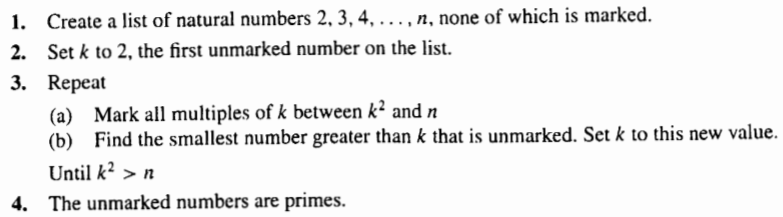

## Secuencial

### Código

In [ ]:
%%writefile criba.c
#include <stdlib.h>
#include <stdio.h>
#include <sys/time.h>

void main(int argc, char **argv) {
    int n = atoi(argv[1]);

    struct timeval tInicial;  // <--- toma de tiempo 1
    gettimeofday(&tInicial, 0);

    n--;

    char *lista = (char *) malloc(n * sizeof(char));
    if (lista == NULL) {
        printf ("Memoria insuficiente para crear el vector.\n");

        exit (1);
    }

    if (lista == NULL) {
      printf("Memoria insuficiente\n");

      return;
    }

    for (int i = 0; i < n; i++) {
        lista[i] = 0;
    }

    int k = 2, sqr_k;

    do {
        sqr_k = k*k;

        for (int i = sqr_k - 2; i < n; i += k) {
            lista[i] = 1;
        }

        for (int i = k - 1; i < n; i++) {
            if (lista[i] == 0) {
                k = i + 2;
                
                break;
            }
        }

    } while (k*k < n);

    int nPrimos = 0;

    for (int i = 0; i < n; i++) {
        if (lista[i] == 0) {
            ++nPrimos;
        }
    }

    struct timeval tFinal;  // <--- toma de tiempo 2
    gettimeofday(&tFinal, 0);

    long segundos = tFinal.tv_sec - tInicial.tv_sec;
    long microsegundos = tFinal.tv_usec - tInicial.tv_usec;
    double tTotal = segundos + (microsegundos * 1e-6);

    printf("\nPrimos encontrados = %d", nPrimos);
    printf("\nTiempo total = %f segundos\n", tTotal);

    free(lista);
}

Overwriting criba.c


### Bash

In [ ]:
%%script bash
gcc criba.c -o criba -lm /* -std=gnu99 */
./criba 500000000


Primos encontrados = 26355867
Tiempo total = 15.278350 segundos

## Paralelo - Versión 1

### Código

In [ ]:
%%writefile criba_v1.c
/*
 *   Sieve of Eratosthenes
 *
 *   Programmed by Michael J. Quinn
 *
 *   Last modification: 7 September 2001
 */

#include "mpi.h"
#include <math.h>
#include <stdio.h>
#include <stdlib.h>


int main (int argc, char *argv[])
{
  int    count;        /* Local prime count */
  double elapsed_time; /* Parallel execution time */
  int    first;        /* Index of first multiple */
  int    global_count; /* Global prime count */
  int    high_value;   /* Highest value on this proc */
  int    i;
  int    id;           /* Process ID number */
  int    index;        /* Index of current prime */
  int    low_value;    /* Lowest value on this proc */
  char  *marked;       /* Portion of 2,...,'n' */
  int    n;            /* Sieving from 2, ..., 'n' */
  int    p;            /* Number of processes */
  int    proc0_size;   /* Size of proc 0's subarray */
  int    prime;        /* Current prime */
  int    size;         /* Elements in 'marked' */

  
  MPI_Init (&argc, &argv);

  /* Start the timer */

  MPI_Comm_rank (MPI_COMM_WORLD, &id);
  MPI_Comm_size (MPI_COMM_WORLD, &p);
  MPI_Barrier(MPI_COMM_WORLD);
  elapsed_time = -MPI_Wtime();

  if (argc != 2) { if (!id) printf ("Command line: %s <m>\n", argv[0]); MPI_Finalize(); exit (1);}

  n = atoi(argv[1]);

  /* Figure out this process's share of the array, as
    well as the integers represented by the first and
    last array elements */

  low_value = 2 + id*(n-1)/p;
 
  high_value = 1 + (id+1)*(n-1)/p;
 
  size = high_value - low_value + 1;
 
  //printf("\n[%d] low_value= %d,  high_value=%d,  size=%d\n", id, low_value, high_value, size);

  /* Bail out if all the primes used for sieving are not all held by process 0 */
  proc0_size = (n-1)/p;
  
  if ((2 + proc0_size) < (int) sqrt((double) n)) { if (!id) printf ("Too many processes\n"); MPI_Finalize();  exit (1); }

  /* Allocate this process's share of the array. */
  marked = (char *) malloc (size);
  if (marked == NULL) {printf ("Cannot allocate enough memory\n"); MPI_Finalize();exit (1);}

  for (i = 0; i < size; i++) marked[i] = 0;
  if (!id) index = 0;
  prime = 2;
  do {      
    if (prime * prime > low_value)
      first = prime * prime - low_value;
    else {
      if (!(low_value % prime)) first = 0;
      else first = prime - (low_value % prime);
    }
   
    for (i = first; i < size; i += prime) marked[i] = 1;
    if (!id) {
      while (marked[++index]);
      prime = index + 2;
    }
    if (p > 1) MPI_Bcast (&prime,  1, MPI_INT, 0, MPI_COMM_WORLD);
  } while (prime * prime <= n);

  count = 0;
  for (i = 0; i < size; i++)
    if (!marked[i]) count++;

  if (p > 1) MPI_Reduce (&count, &global_count, 1, MPI_INT, MPI_SUM, 0, MPI_COMM_WORLD);
  free(marked);
  // Stop the timer 

  elapsed_time += MPI_Wtime();

  // Print the results 

  if (!id) {
    if(p>1) printf ("There are %d primes less than or equal to %d\n", global_count, n);
    else printf ("There are %d primes less than or equal to %d\n", count, n);
    printf ("SIEVE (%d) %10.6f segs\n", p, elapsed_time);
  }
  MPI_Finalize ();
  return 0;
}

Overwriting criba_v1.c


### Bash

In [ ]:
%%script bash
mpicc criba_v1.c -o criba_v1 -lm
mpiexec --allow-run-as-root -np 5 criba_v1 500000000

Process is terminated.


## Paralelo - Versión 2

### Código

In [ ]:
%%writefile criba_v2.c
/*
 *   Sieve of Eratosthenes
 *
 *   In this version only odd integers are represented.
 *
 *   Programmed by Michael J. Quinn
 *
 *   Last modification: 4 September 2001
 */

#include "mpi.h"
#include <math.h>
#include <stdio.h>
#include <stdlib.h>
#define MIN(a,b)  ((a)<(b)?(a):(b))

int main (int argc, char *argv[])
{
  double elapsed_time;
  int   els;
  int   global_count;
  int   high_value;
  int   i, m, count;
  int   id;
  int   index, prime, first, step;
  int   larger_size;
  int   local_count;
  int   low_value;
  char *marked;
  int   num_larger_blocks;
  int   p;
  int   proc0_size;
  int   smaller_size;
  int   size;

  MPI_Init (&argc, &argv);
  MPI_Comm_rank (MPI_COMM_WORLD, &id);
  MPI_Comm_size (MPI_COMM_WORLD, &p);
  elapsed_time = - MPI_Wtime();

  if (argc != 2) {
  if (!id) printf ("Command line: %s <m>\n", argv[0]);
  MPI_Finalize();
  exit (1);
  }

  m = atoi(argv[1]);
  els = (m-1) / 2;       /* Only odd integers will be represented */

  /* Figure out this process's share of the array, as well as the
    integers represented by the first and last array elements */

  smaller_size = els/p;
  larger_size = smaller_size + 1;
  num_larger_blocks = els % p;
  if (id < num_larger_blocks) size = larger_size;
  else size = smaller_size;

  low_value = 2*(id*smaller_size + MIN(id, num_larger_blocks)) + 3;
  high_value = low_value + 2*(size - 1);

  if (num_larger_blocks > 0) proc0_size = larger_size;
  else proc0_size = smaller_size;

  if ((1 + 2*proc0_size) < (int) sqrt((double)m)) {
  if (!id) printf ("Too many processes, given upper bound of sieve\n");
  if (!id) printf ("proc0_size is %d and m is %d\n", proc0_size, m);
  MPI_Finalize();
  exit (1);
  }

  /* Allocate this process's share of the array. */

  marked = (char *) malloc (size);

  if (marked == NULL) {
  printf ("Cannot allocate enough memory\n");
  MPI_Finalize();
  exit (1);
  }

  for (i = 0; i < size; i++) marked[i] = 0;
  if (!id) index = 0;
  prime = 3;
  do {
    if (prime * prime > low_value) first = (prime * prime - low_value)/2;
    else {
      int r = low_value % prime;
      if (!r) first = 0;
      else 
        if ((prime - r) & 1)
          first = (2*prime - r)/2;
        else first = (prime - r)/2;
    }
    for (i = first; i < size; i += prime) marked[i] = 1;
    if (!id) {
      while (marked[++index]);
      prime = 2*index + 3;
    }
    MPI_Bcast (&prime,  1, MPI_INT, 0, MPI_COMM_WORLD);
  } while (prime * prime <= m);

  count = 0;
  for (i = 0; i < size; i++)
    if (!marked[i]) count++;

  MPI_Reduce (&count, &global_count, 1, MPI_INT, MPI_SUM, 0, MPI_COMM_WORLD);
  free(marked);
  global_count++;   /* To account for the only even prime, 2 */

  elapsed_time += MPI_Wtime();

  if (!id) {
  printf ("There are %d primes less than or equal to %d\n", global_count, m);
  printf ("SIEVE_ODD (%d) %10.6f\n", p, elapsed_time);
  }

  MPI_Finalize ();
  return 0;
}


Overwriting criba.c


### Bash

In [ ]:
%%script bash
mpicc criba_v2.c -o criba_v2 -lm
mpiexec --allow-run-as-root -np 3 criba_v2 500000000 

## Paralelo - Versión 3

### Código

In [ ]:
%%writefile criba_v3.c
/*
 *   Sieve of Eratosthenes
 *
 *   This MPI program computes the number of prime numbers
 *   less than N, where N is a command-line argument.
 *
 *   Enhancements:
 *      Only odd integers are represented
 *      Each process finds its own prime sieve values: there
 *         is no broadcast step
 *
 *   Programmer: Michael J. Quinn
 *
 *   Last modification: 6 September 2001
 */

#include "mpi.h"
#include <math.h>
#include <stdio.h>
#include <stdlib.h>
#define MIN(a,b)  ((a)<(b)?(a):(b))

int main (int argc, char *argv[])
{
   int    current_prime;     /* Sieve by this prime */
   double elapsed_time;      /* Stopwatch */
   int    id_num;            /* Process rank */
   int    n;                 /* Top integer to check */
   int    p;                 /* Number of processors */
   int    sqrt_n;            /* Top value for sieve primes */
   char  *small_primes;      /* 1's show primes to sqrt(n) */
   char  *primes;            /* Share of values 3..n */
   int    small_prime_count; /* Number of sieve primes */
   int   *small_prime_values;/* Array of sieving primes */
   int    index;             /* Sieving location */
   int    i, j, k;
   int    size;              /* Size of array 'primes' */
   int    prime_count;       /* Primes on this proc */
   int    low_proc_value;    /* Smallest int on this proc */
   int    high_proc_value;   /* Highest int on this proc */
   int    smaller_size;      /* Smaller block size */
   int    larger_size;
   int    num_larger_blocks;
   int blocks;
   int low;
   int high;
   int global_count;
   int small_prime_array_size;
   int els;
   
  int seq_sieve (char *, int , int );
   MPI_Init (&argc, &argv);
   MPI_Barrier(MPI_COMM_WORLD);
   elapsed_time = -MPI_Wtime();
   n = atoi (argv[1]);
 
   MPI_Comm_rank (MPI_COMM_WORLD, &id_num);
   MPI_Comm_size (MPI_COMM_WORLD, &p);
 
   sqrt_n = (int) sqrt((double) n);
   small_prime_array_size = (sqrt_n - 1)/2;
   small_primes = (char *) malloc (small_prime_array_size);
   small_prime_count = seq_sieve (small_primes, small_prime_array_size, sqrt_n);
   small_prime_values = (int *) malloc (small_prime_count * sizeof(int));
   index = 0;
   for (i = 0; i < small_prime_array_size; i++)
      if (small_primes[i]) {
         small_prime_values[index++] = 2*i+3;
      }
   els = (n-1) / 2;
   smaller_size = els / p;
   larger_size = smaller_size + 1;
   num_larger_blocks = els % p;
   if (id_num < num_larger_blocks) size = larger_size;
   else size = smaller_size;
 
   low_proc_value = 2*(id_num*smaller_size + MIN(id_num, num_larger_blocks)) + 3;
   high_proc_value = low_proc_value + 2 * (size-1);
 
   primes = (char *) malloc (size);


   for (j = 0; j < size; j++) primes[j] = 1;

   for (j = 0; j < small_prime_count; j++) {
      current_prime = small_prime_values[j];
      if (current_prime * current_prime > low_proc_value)
         index = (current_prime * current_prime - low_proc_value)/2;
      else {
         int r = low_proc_value % current_prime;
         if (!r) index = 0;
         else 
          if ((current_prime - r) & 1)
            index = (2*current_prime - r)/2;
          else 
            index = (current_prime - r)/2;
      }
      if (index >= size) break;
      for (k = index; k < size; k+= current_prime)
         primes[k] = 0;
   }

   prime_count = 0;
   for (j = 0; j < size; j++)
      if (primes[j]) prime_count++;
 
   MPI_Reduce (&prime_count, &global_count, 1, MPI_INT, MPI_SUM, 0, MPI_COMM_WORLD);
 

  free(primes);
  free(small_primes);
  free(small_prime_values);

   if (!id_num) global_count++;   /* To account for only even prime, 2 */
   elapsed_time += MPI_Wtime();
   if (!id_num) {
      printf ("Total prime count is %d\n", global_count);
      printf ("SIEVE_ODD_NO_BCAST (%d) %10.6f segs\n", p, elapsed_time);
   }
   MPI_Finalize();
   return 0;
}
//--------------------------------------------------------------------
int seq_sieve (char *small_primes, int small_prime_array_size, int sqrt_n)
{
   int i, j;
   int prime_index;
   int prime_value;
   int count;

   /* small_primes[i] represents integer 2i+3 */

   for (i = 0; i < small_prime_array_size; i++) small_primes[i] = 1;
 
   prime_index = 0;
   prime_value = 3;
   while (prime_value * prime_value <= sqrt_n) {
      j = prime_value * prime_value / 2 - 1;
      while (j < small_prime_array_size) {
         small_primes[j] = 0;
         j += prime_value;
      }
      while (small_primes[++prime_index] == 0);
      prime_value = 2*prime_index + 3;
   }
   count = 0;
   for (i = 0; i < small_prime_array_size; i++)
      if (small_primes[i] == 1) {
         count++;
      }
   return count;
}


Overwriting criba.c


### Bash

In [ ]:
%%script bash
mpicc criba_v3.c -o criba_v3 -lm
mpiexec --allow-run-as-root -np 3 criba_v3 500000000 >> time.dat